# Bayes by Backprop

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [266]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb
y_train_categorical = tfk.utils.to_categorical(y_train, 2)
y_test_categorical = tfk.utils.to_categorical(y_test, 2)

[0. 1.] 1


In [295]:
# Bayes by Backprop parameters

# model save file
model_save_file = "./models/bayes_by_backprop.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the number of neurons
n_hidden = [32, 32]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# GloVe Word Embedding

In [6]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [7]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [294]:
# https://github.com/tensorflow/probability/issues/282

def kernel_divergence_fn(q, p, _):
    return tfd.kl_divergence(q, p) / tf.cast(x_train_padded.shape[0] * (1 - validation_split), tf.float32)

def create_model():
    model = tfk.Sequential()
    
    model.add(tfkl.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    for i in range(len(n_hidden)):
        model.add(tfpl.DenseFlipout(
            n_hidden[i], activation='relu', kernel_divergence_fn=kernel_divergence_fn))
    model.add(tfkl.Flatten())
    model.add(tfpl.DenseFlipout(2, activation="softmax", kernel_divergence_fn=kernel_divergence_fn))
    
    model.compile(optimizer=tfk.optimizers.Adam(0.001), loss=tfk.losses.categorical_crossentropy, metrics=['acc'])
    
    return model

try:
    model = create_model()
    model.load_weights(model_save_file)
    
    # https://github.com/tensorflow/probability/issues/325
    # model = tfk.models.load_model(model_save_file)
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")
model.summary()

using saved model
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 2697, 50)          4429400   
_________________________________________________________________
dense_flipout_30 (DenseFlipo (None, 2697, 32)          3232      
_________________________________________________________________
dense_flipout_31 (DenseFlipo (None, 2697, 32)          2080      
_________________________________________________________________
flatten_42 (Flatten)         (None, 86304)             0         
_________________________________________________________________
dense_flipout_32 (DenseFlipo (None, 2)                 345218    
Total params: 4,779,930
Trainable params: 350,530
Non-trainable params: 4,429,400
_________________________________________________________________


In [296]:
# keras callbacks
tb_callback = tfk.callbacks.TensorBoard(log_dir='logs') 
model_checkpoint_cb = tfk.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=0, 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      mode='auto')

model.fit(x_train_padded, 
          y_train_categorical, 
          validation_split=validation_split, 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=[tb_callback, model_checkpoint_cb])

Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 18s 767us/sample - loss: 17.9516 - acc: 0.6420 - val_loss: 17.2964 - val_acc: 0.7408
Epoch 2/20
23750/23750 [==============================] - 17s 705us/sample - loss: 16.7160 - acc: 0.7574 - val_loss: 16.1196 - val_acc: 0.7848
Epoch 3/20
23750/23750 [==============================] - 17s 704us/sample - loss: 15.5497 - acc: 0.7888 - val_loss: 14.9805 - val_acc: 0.8016
Epoch 4/20
23750/23750 [==============================] - 17s 707us/sample - loss: 14.4062 - acc: 0.8020 - val_loss: 13.8595 - val_acc: 0.8088
Epoch 5/20
23750/23750 [==============================] - 17s 708us/sample - loss: 13.2714 - acc: 0.8146 - val_loss: 12.7353 - val_acc: 0.8176
Epoch 6/20
23750/23750 [==============================] - 17s 706us/sample - loss: 12.1731 - acc: 0.8190 - val_loss: 11.6497 - val_acc: 0.8264
Epoch 7/20
23750/23750 [==============================] - 17s 705us/sample - loss: 11.0919 - 

In [297]:
loss, accuracy = model.evaluate(x_test_padded, y_test_categorical)
print("Test loss: %.2f\nTest accuracy: %.2f%%" % (loss, accuracy * 100))

25000/25000 [==============================] - 21s 840us/sample - loss: 2.1394 - acc: 0.8254
Test loss: 2.14
Test accuracy: 82.54%


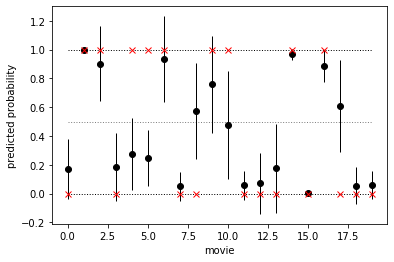

In [302]:
def plot_confidence(means, stddevs, true_ys):
    x = np.arange(0, len(means), 1)
    y = means
    yerr = np.array(stddevs) * 2

    fig, ax = plt.subplots()
    plt.xlabel("movie")
    plt.ylabel("predicted probability")
    
    ax.hlines(y=[0, 0.5, 1], xmin=0, xmax=len(x) - 1, linewidth=1, linestyle=":", color=["black", "gray", "black"])
    ax.errorbar(x, y, yerr=yerr, fmt="o", elinewidth=1, color="black")
    ax.errorbar(x, true_ys, fmt="x", color="r")
    plt.show()


n = 20
samples = 75
y_pred = []
for i in range(samples):
    prediction = model.predict(x_test_padded[:n])
    y_pred += [prediction[:, 1]]

    
y_pred = np.array(y_pred)
means = [np.mean(y_pred[:, i]) for i in range(n)]
stddevs = [np.std(y_pred[:, i]) for i in range(n)]
plot_confidence(means, stddevs, y_test[:n])

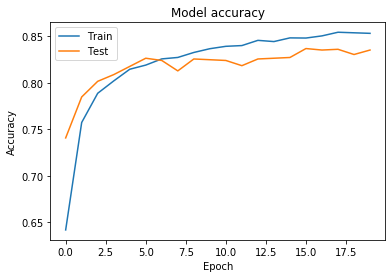

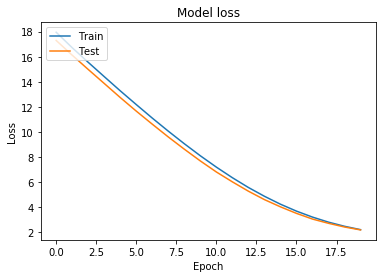

In [299]:
if hasattr(model, "history"):
    history = model.history

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()